# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [1]:
!unzip "/content/archive (5).zip" -d data/

Archive:  /content/archive (5).zip
replace data/Forest Recordings/recording_00.mp3? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
!ls data

'Forest Recordings'   Parsed_Capuchinbird_Clips   Parsed_Not_Capuchinbird_Clips


## 1.2 Load Dependencies

In [3]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [4]:
CAPUCHIN_FILE = os.path.join('/content','data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('/content','data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [5]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot Wave

In [6]:
NOT_CAPUCHIN_FILE

'/content/data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav'

In [7]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

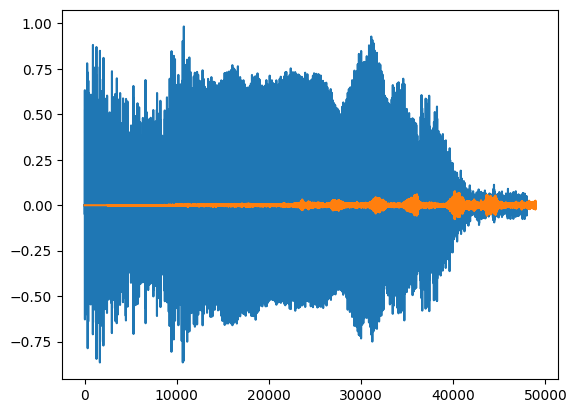

In [8]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [9]:
POS = os.path.join('/content','data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content','data', 'Parsed_Not_Capuchinbird_Clips')

In [10]:
POS

'/content/data/Parsed_Capuchinbird_Clips'

## 3.2 Create Tensorflow Datasets

In [11]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [12]:
len(pos)

217

In [13]:
len(neg)

593

## 3.3 Add labels and Combine Positive and Negative Samples

In [14]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg.take(len(pos)), tf.data.Dataset.from_tensor_slices(tf.zeros(len(pos))))) # Undersample negative dataset
data = positives.concatenate(negatives)

# Shuffle the combined dataset
data = data.shuffle(buffer_size=1000)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [15]:
lengths = []
for file in os.listdir(os.path.join('/content','data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('/content','data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [16]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [17]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [18]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [19]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    # Explicitly set the shape to ensure it's static for the model
    spectrogram.set_shape([1491, 257, 1])
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [20]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [21]:
spectrogram, label = preprocess(filepath, label)

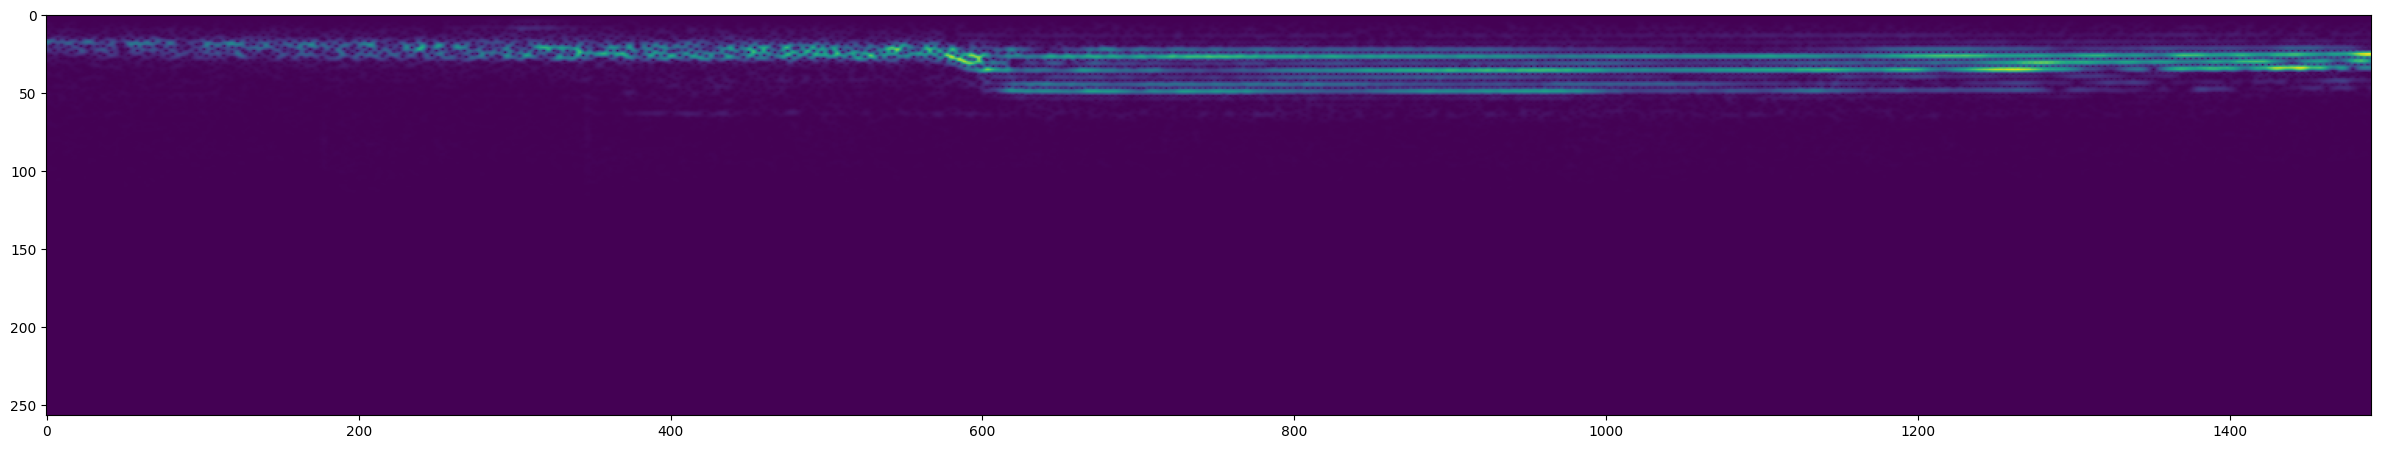

In [22]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [23]:
data = data.map(preprocess)
# data = data.cache() # Removed caching to save RAM
data = data.shuffle(buffer_size=200) # Reduced shuffle buffer size
data = data.batch(4) # Reduced batch size further
data = data.prefetch(2) # Also reduce prefetch buffer size

## 6.2 Split into Training and Testing Partitions

In [24]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [25]:
samples, labels = train.as_numpy_iterator().next()

In [26]:
samples.shape

(4, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [28]:
model = Sequential()
model.add(Conv2D(8, (3,3), activation='relu', input_shape=(1491, 257,1))) # Reduced filters
model.add(Conv2D(8, (3,3), activation='relu')) # Reduced filters
model.add(Flatten())
model.add(Dense(64, activation='relu')) # Also reduced dense units for further memory saving
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1489, 255, 8)   │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1487, 253, 8)   │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3009688)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │   192,620,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,620,825 (734.79 MB)

 Trainable params: 192,620,825 (734.79 MB)

 Non-trainable params: 0 (0.00 B)

## 7.3 Fit Model, View Loss and KPI Plots

In [31]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 169s 4s/step - loss: 7.2877 - precision: 0.6962 - recall: 0.8308 - val_loss: 0.2801 - val_precision: 1.0000 - val_recall: 0.9118
Epoch 2/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - loss: 0.2564 - precision: 0.8946 - recall: 0.9292 - val_loss: 0.1069 - val_precision: 0.9667 - val_recall: 1.0000
Epoch 3/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - loss: 0.8540 - precision: 0.9747 - recall: 1.0000 - val_loss: 0.0327 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - loss: 0.6130 - precision: 0.9514 - recall: 0.9441 - val_loss: 0.1011 - val_precision: 0.9643 - val_recall: 0.9643


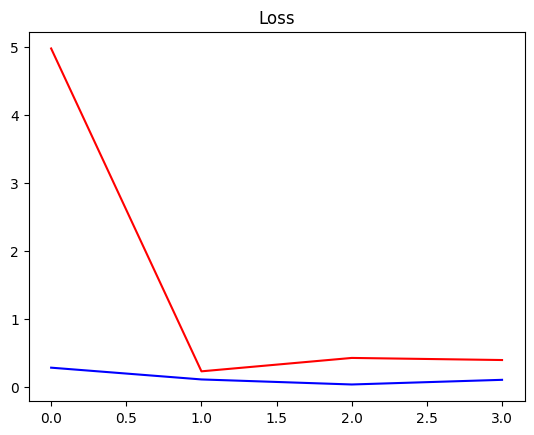

In [32]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

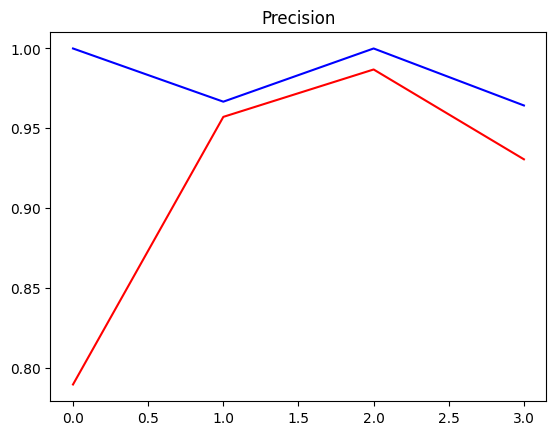

In [33]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

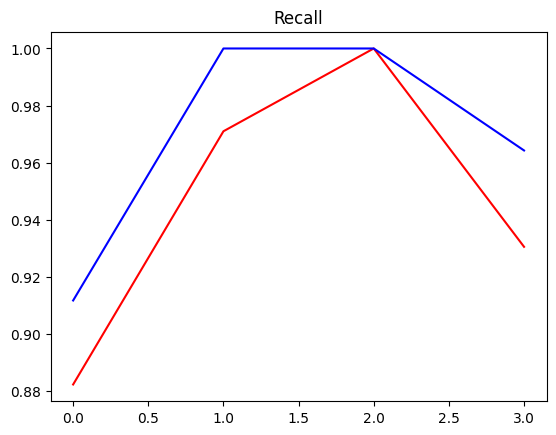

In [34]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [35]:
X_test, y_test = test.as_numpy_iterator().next()

In [36]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


## 8.2 Convert Logits to Classes

In [37]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [38]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [39]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [40]:
wav = load_mp3_16k_mono(mp3)

In [41]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [42]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [43]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [44]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [45]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step


## 9.4 Group Consecutive Detections

In [46]:
from itertools import groupby

In [47]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [48]:
calls

8

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [49]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [50]:
results

{'recording_16.mp3': array([[0.49455488],
        [0.4854711 ],
        [0.4681833 ],
        [0.46812212],
        [0.55310386],
        [0.51809573],
        [0.48092648],
        [0.6469669 ],
        [0.468067  ],
        [0.5441228 ],
        [0.5661068 ],
        [0.5121375 ],
        [0.55553037],
        [0.6945269 ],
        [0.58193964],
        [0.5533398 ],
        [0.62785405],
        [0.9989076 ],
        [0.6419431 ],
        [0.6193343 ],
        [0.61628693],
        [0.5924305 ],
        [0.6008366 ],
        [0.5044159 ],
        [0.90156686],
        [0.99999166],
        [0.4948929 ],
        [0.4674083 ],
        [0.5167949 ],
        [0.49889892],
        [0.4954998 ],
        [0.5210964 ],
        [0.56665707],
        [0.4842057 ],
        [0.59934616],
        [0.69408965],
        [0.8017347 ],
        [0.8591348 ],
        [0.58069867],
        [0.76152706],
        [0.55706614],
        [0.6233711 ],
        [0.51645833],
        [0.54918003],
        [0.7

## 10.2 Convert Predictions into Classes

In [51]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_16.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_27.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_47.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0],
 'recording_35.mp3': [0,
  0,
  0,
  

## 10.3 Group Consecutive Detections

In [52]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_16.mp3': 3,
 'recording_27.mp3': 0,
 'recording_47.mp3': 4,
 'recording_35.mp3': 0,
 'recording_89.mp3': 3,
 'recording_98.mp3': 20,
 'recording_73.mp3': 0,
 'recording_85.mp3': 0,
 'recording_11.mp3': 2,
 'recording_24.mp3': 0,
 'recording_51.mp3': 3,
 'recording_32.mp3': 2,
 'recording_12.mp3': 0,
 'recording_26.mp3': 2,
 'recording_84.mp3': 2,
 'recording_37.mp3': 3,
 'recording_31.mp3': 1,
 'recording_55.mp3': 0,
 'recording_21.mp3': 1,
 'recording_20.mp3': 0,
 'recording_86.mp3': 4,
 'recording_58.mp3': 0,
 'recording_13.mp3': 0,
 'recording_00.mp3': 5,
 'recording_49.mp3': 0,
 'recording_09.mp3': 0,
 'recording_97.mp3': 4,
 'recording_22.mp3': 2,
 'recording_90.mp3': 0,
 'recording_04.mp3': 4,
 'recording_69.mp3': 1,
 'recording_38.mp3': 1,
 'recording_95.mp3': 5,
 'recording_52.mp3': 0,
 'recording_78.mp3': 2,
 'recording_29.mp3': 0,
 'recording_06.mp3': 5,
 'recording_70.mp3': 2,
 'recording_39.mp3': 2,
 'recording_45.mp3': 3,
 'recording_28.mp3': 4,
 'recording_44.

# 11. Export Results

In [53]:
import csv

In [54]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])